In [37]:
import pandas as pd
import numpy as np

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filepath = "./GEO Samples/Ov_merged_data_with_metadata.csv"
ov_samples = pd.read_csv(filepath)

In [3]:
# Drop ID and lable column
X = ov_samples.drop(['ID', 'Stage'], axis=1, inplace=False)
y = ov_samples[['Stage']]
y['Stage'].value_counts()

Stage
3    331
1    265
2     72
4     32
Name: count, dtype: int64

### Remove Outlires

In [4]:
from sklearn.ensemble import IsolationForest

# Initialize the model
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Fit the model
iso_forest.fit(X)

# Predict outliers
outlier_labels_iso = iso_forest.predict(X)  # -1 for outliers, 1 for inliers

print(Counter(outlier_labels_iso))

outlier_indices_iso = np.where(outlier_labels_iso == -1)[0]
outlier_indices_iso

Counter({1: 669, -1: 31})


array([  3,   8,  43,  45,  56,  77,  86, 100, 101, 138, 174, 175, 183,
       223, 266, 355, 369, 388, 398, 414, 432, 448, 453, 487, 505, 508,
       543, 573, 598, 627, 681], dtype=int64)

In [5]:
from sklearn.decomposition import PCA


# Fit PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X)
X_reconstructed = pca.inverse_transform(X_pca)

# Calculate reconstruction error
reconstruction_error = np.mean((X - X_reconstructed) ** 2, axis=1)

# Determine outliers based on a threshold
threshold = np.percentile(reconstruction_error, 95)
outlier_labels_pca = reconstruction_error > threshold

print(Counter(outlier_labels_pca))

outlier_indices_pca = np.where(outlier_labels_pca == True)[0]
outlier_indices_pca

Counter({False: 666, True: 34})


array([ 42,  43,  94,  95, 101, 138, 174, 175, 223, 266, 270, 275, 285,
       292, 301, 338, 356, 360, 362, 365, 414, 429, 476, 513, 514, 543,
       598, 627, 633, 650, 682, 684, 686, 689], dtype=int64)

In [6]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize the model
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')

# Fit the model and predict outliers
outlier_labels_lof = lof.fit_predict(X)  # -1 for outliers, 1 for inliers
print(Counter(outlier_labels_lof))

outlier_indices_lof = np.where(outlier_labels_lof == -1)[0]
outlier_indices_lof

Counter({1: 672, -1: 28})


array([ 43,  95, 118, 174, 175, 223, 249, 266, 292, 312, 325, 338, 350,
       355, 356, 370, 371, 374, 414, 442, 514, 530, 598, 627, 658, 681,
       682, 692], dtype=int64)

In [7]:
# Convert to sorted list (optional, for ordered output)

# # Compare overlap
overlap = set(outlier_indices_pca) & set(outlier_indices_lof)
print(f"Overlap count: {len(overlap)}")
print(f"Overlap indices: {sorted(overlap)}")


overlap_sorted = sorted(overlap)


Overlap count: 14
Overlap indices: [43, 95, 174, 175, 223, 266, 292, 338, 356, 414, 514, 598, 627, 682]


In [8]:
# # Compare overlap
overlap = set(outlier_indices_pca) & set(outlier_indices_lof) & set(outlier_indices_iso) 
print(f"Overlap count: {len(overlap)}")
print(f"Overlap indices: {sorted(overlap)}")


overlap_sorted = sorted(overlap)

Overlap count: 8
Overlap indices: [43, 174, 175, 223, 266, 414, 598, 627]


In [9]:
# Drop the outliers!
X = X.drop(overlap_sorted).reset_index(drop=True)
y = y.drop(overlap_sorted).reset_index(drop=True)

print(X.shape)
y['Stage'].value_counts()

(692, 2550)


Stage
3    325
1    263
2     72
4     32
Name: count, dtype: int64

## Select 128 Samples - 32 of each

In [10]:
# Select 128 Samples - 32 of each

df = X.copy()
df['Stage'] = y['Stage'].values 

# Group by class and sample 25 from each
df_sampled = df.groupby('Stage', group_keys=False).sample(n=32, random_state=19)

# Split back into X and y
X = df_sampled.drop(columns='Stage')
y = df_sampled[['Stage']]
y['Stage'].value_counts()

Stage
1    32
2    32
3    32
4    32
Name: count, dtype: int64

## Split the data

In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=20)


In [ ]:
# y_train['Stage'].value_counts()

##  OverSampling / UnderSampling

In [ ]:
# # Oversample rows where y == 4

# # Stage 4 originally has 32 samples. We repute each one 8 times = 288
# n = 8
# mask = y_train['Stage'] == 4

# X_Stage_4 = X_train[mask]
# y_Stage_4 = y_train[mask]
# y_Stage_4

# X_train_oversampled = pd.concat([X_train, pd.concat([X_Stage_4]*n)], ignore_index=True)
# y_train_oversampled = pd.concat([y_train, pd.concat([y_Stage_4]*n)], ignore_index=True)


# # Oversample rows where y == 2
# # Stage 2 originally has 72 samples. We repute each one 3 times = 288
# n = 3
# mask = y_train["Stage"] == 2

# X_Stage_2 = X_train[mask]
# y_Stage_2 = y_train[mask]

# X_train_oversampled = pd.concat([X_train_oversampled, pd.concat([X_Stage_2]*n)], ignore_index=True)
# y_train_oversampled = pd.concat([y_train_oversampled, pd.concat([y_Stage_2]*n)], ignore_index=True)

# y_train_oversampled['Stage'].value_counts()

In [ ]:
# from imblearn.over_sampling import BorderlineSMOTE

# # Apply Borderline-SMOTE
# smote = BorderlineSMOTE(random_state=42)
# X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# y_train_oversampled['Stage'].value_counts()

In [ ]:
# # Shuffle the oversampled training data
# shuffled = X_train_oversampled.join(y_train_oversampled).sample(frac=1, random_state=42).reset_index(drop=True)
# X_train = shuffled.drop(columns='Stage')
# y_train = shuffled['Stage']

In [ ]:
# print("Train min:", X_train.min().min())
# print("Train max:", X_train.max().max())
# print("Test min:", X_test.min().min())
# print("Test max:", X_test.max().max())

## Normalization

In [12]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

# Fit and transform the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# # Normalization with Min-Max
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()

# # Fit and transform the data
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


In [13]:
normalized_train_samples = pd.DataFrame(X_train_scaled, columns= X.columns)
normalized_test_samples = pd.DataFrame(X_test_scaled, columns= X.columns)

X_train = normalized_train_samples.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = normalized_test_samples.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [14]:
# # ==================================
# # Save Normalized Data into file
# # ==================================


# # Concate normalized data and lables:
# train_normalized = pd.concat([y_train, X_train], axis=1)
# filepath = "./GEO Samples/train_data_Normalized.csv"
# train_normalized.to_csv(filepath, index=False)


# test_normalized = pd.concat([y_test, X_test], axis=1)
# filepath = "./GEO Samples/test_data_Normalized.csv"
# test_normalized.to_csv(filepath, index=False)

## Feature Selection


In [ ]:
# # Train Random Forest on full data and get feature importances
# from sklearn.ensemble import RandomForestClassifier
# import numpy as np

# x = X_train
# y = y_train
# k = 200
# # Train a model
# model = RandomForestClassifier(n_estimators=k, random_state=42, class_weight='balanced')
# model.fit(x, y["Stage"])

# # Get feature importances and select top k
# RF_importances = model.feature_importances_
# indices = np.argsort(RF_importances)[::-1]  # Sort descending


# top_indices = indices[:k]
# print(top_indices.shape)

# top_indices

In [ ]:
# from sklearn.feature_selection import mutual_info_classif, SelectKBest

# mi_selector = SelectKBest(score_func=mutual_info_classif, k=k)
# x_mi_selected = mi_selector.fit_transform(x, y["Stage"])

# # Get the actual indices of selected features
# mi_indices = mi_selector.get_support(indices=True)
# mi_indices

In [ ]:
# # Get the overlap

# # Get top k feature indices by model importance
# top_k_model_indices = np.argsort(RF_importances)[::-1][:k]

# # Compare overlap
# overlap = set(mi_indices) & set(top_k_model_indices)
# print(f"Overlap count: {len(overlap)} out of {k}")
# print(f"Overlap indices: {sorted(overlap)}")


# # Convert to sorted list (optional, for ordered output)
# selected_features = sorted(overlap)

# # Get corresponding feature names
# overlap_feature_names = x.columns[selected_features]

# # Display or use them
# print("\n" , overlap_feature_names)

In [ ]:
# # Get the Union

# from collections import OrderedDict
# selected_features = list(set(top_indices).union(set(mi_indices)))
# len(selected_features)

In [ ]:
# X_train = x.iloc[:, sorted(selected_features)]
# X_train

In [ ]:
# X_test = X_test.iloc[:, sorted(selected_features)]
# X_test

## Plot 2D PCA

In [ ]:
# y = y_train

In [ ]:
# from sklearn.decomposition import PCA


# # Reduce to 2 principal components
# pca = PCA(n_components=2)
# x_pca = pca.fit_transform(X_train)

# df_pca = pd.DataFrame(x_pca, columns=["PC1", "PC2"])
# df_pca["Stage"] = y.values


# # Plot PCA
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(
#     df_pca["PC1"], df_pca["PC2"],
#     c=y["Stage"],
#     cmap='viridis',        # Try 'Set1', 'tab20', or 'nipy_spectral' for more color variety
#     alpha=0.5           # Higher opacity
# )
# plt.legend(*scatter.legend_elements(), title="Stage", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.title("2D PCA of Cancer Detection")
# plt.xlabel("PC 1")
# plt.ylabel("PC 2")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
# # Drop the Outliers!

# df = df_pca
# s1 = df_pca[df_pca["PC1"] > 3.5]
# df = df.drop(s1.index.tolist())

# # Step 4: Seaborn scatterplot
# plt.figure(figsize=(8, 6))
# sns.scatterplot(
#     data=df,
#     x="PC1", y="PC2",
#     hue="Stage",
#     palette="viridis",
#     alpha=0.5,
#     s=60
# )
# plt.title("2D PCA of Cancer Detection - No outlier")
# plt.xlabel("PC 1")
# plt.ylabel("PC 2")
# plt.grid(True)
# plt.legend(title="Stage", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.tight_layout()
# plt.show()

In [ ]:
# # Plot class 3 & 4

# data = pd.concat([y_train, X_train], axis=1)
# df_filtered = data[data['Stage'].isin([3, 4])]
# xx = df_filtered.drop(["Stage"], axis = 1)
# yy = df_filtered[['Stage']]


# from sklearn.decomposition import PCA


# # Reduce to 2 principal components
# pca = PCA(n_components=2)
# x_pca = pca.fit_transform(xx)

# df_pca = pd.DataFrame(x_pca, columns=["PC1", "PC2"])
# df_pca["Stage"] = yy.values


# # Plot PCA
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(
#     df_pca["PC1"], df_pca["PC2"],
#     c=yy["Stage"],
#     cmap='viridis',        # Try 'Set1', 'tab20', or 'nipy_spectral' for more color variety
#     alpha=0.5           # Higher opacity
# )
# plt.legend(*scatter.legend_elements(), title="Stage", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.title("2D PCA of Cancer Detection stage 3 and 4")
# plt.xlabel("PC 1")
# plt.ylabel("PC 2")
# plt.grid(True)
# plt.tight_layout()

## Classification

In [20]:
X_train

,Age,MIMAT0004501,MIMAT0002844,MIMAT0002843,MIMAT0002824,MIMAT0002823,MIMAT0002807,MIMAT0002806,MIMAT0001635,MIMAT0001631,...,MIMAT0022965,MIMAT0022948,MIMAT0027678,MIMAT0027677,MIMAT0027662,MIMAT0027661,MIMAT0027646,MIMAT0027645,MIMAT0027630,MIMAT0027629
0,0.000000,-0.259084,-0.301525,0.007321,0.045533,-0.282733,-0.745301,-0.450800,-0.125297,3.142415,...,-0.466299,-0.107376,-0.155138,-0.037278,-0.507953,-0.307463,-0.295743,0.112904,-0.196983,-0.461532
1,-0.271186,-1.206626,-1.463473,-1.155004,-1.524735,-1.282586,-1.475287,-1.714657,-1.379111,-0.735523,...,-0.813282,-1.616738,-0.987675,-1.217295,-1.302227,-1.053868,-0.938572,-1.310643,-1.267247,-1.877732
2,0.271186,2.344662,2.793099,1.678253,1.675794,1.787970,0.927127,1.637808,1.496597,0.012591,...,0.332156,1.291438,1.526440,0.900030,0.855690,1.515896,0.548359,1.284015,1.431500,0.823158
3,1.220339,0.558349,0.790591,0.353194,0.420152,0.358094,0.341860,0.537059,0.383538,-0.371074,...,0.230144,0.123506,0.376636,0.394307,0.270060,0.490281,0.252857,0.477107,0.052621,0.146397
4,-0.271186,-0.912820,-0.877473,-0.859693,-1.003892,-0.683602,-1.311465,-0.826869,-0.535660,-0.526756,...,-0.980626,-1.400014,-0.938530,-1.013569,-0.863952,-0.743443,-1.088110,-1.270359,-0.988092,-1.080908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.000000,0.144795,0.353703,-0.034425,1.067116,-0.164026,0.081111,-0.106426,0.061280,0.012757,...,0.463131,1.563121,1.252321,0.411010,0.764159,1.143161,0.151704,1.459940,1.177094,0.147439
98,-0.881356,-0.261075,-0.139820,-0.686116,-0.355418,-0.723046,-0.029693,-0.240457,-0.466160,0.792876,...,0.331550,0.918857,-0.002286,0.071901,-0.120618,-0.036156,-0.103526,0.191803,0.088610,1.019336
99,0.067797,0.825360,0.662230,0.448155,0.064873,1.252889,1.081760,2.141750,2.036667,0.490735,...,1.120763,-0.079453,-0.187855,0.344371,-0.013165,0.033302,0.604704,0.065235,-0.156306,0.275293
100,-0.677966,0.691393,0.783747,0.567753,1.043305,0.613661,1.012316,0.022439,0.444647,4.126131,...,0.718095,1.291826,1.546937,0.525881,1.113185,1.217130,0.674000,2.010596,1.650842,0.908019


SyntaxError: unexpected EOF while parsing (<ipython-input-41-2e36f9810b0f>, line 33)

In [44]:
from sklearn.neural_network import MLPClassifier

MLP_model = MLPClassifier(
    hidden_layer_sizes=(10,50,4),
    activation='relu',
    solver='adam',
    max_iter=1,
    warm_start=True,
    random_state=19
)

# MLP_model.fit(X_train, y_train["Stage"])

n_steps = 50  # Total training steps (iterations)
weights_over_time = []

for i in range(n_steps):
    MLP_model.fit(X_train, y_train.values.ravel())  # Incremental training

    # Save copy of weights of first hidden layer
    w = MLP_model.coefs_[0].copy()  # shape: (n_features, 10)
    weights_over_time.append(w.T)  # transpose for neuron-major layout

weights_over_time = np.array(weights_over_time)

# # Access weights (list of arrays: one per layer)
# weights = MLP_model.coefs_
# print("weights:\n", weights)

# # Access biases (list of arrays: one per layer)
# biases = MLP_model.intercepts_


C:\Users\aisa\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


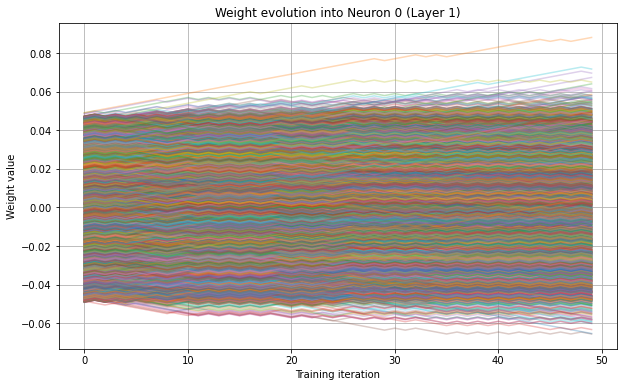

In [45]:

# --------------------
# Plot evolution of input weights to a single neuron
# -------------------
plt.figure(figsize=(10, 6))
for i in range(weights_over_time.shape[2]):  # Loop over input features
    plt.plot(range(n_steps), weights_over_time[:, 0, i], alpha=0.3)

plt.title("Weight evolution into Neuron 0 (Layer 1)")
plt.xlabel("Training iteration")
plt.ylabel("Weight value")
plt.grid(True)
plt.show()


In [ ]:

# ======================
# Predict on tain set
# ======================

y_pred = MLP_model.predict(X_train)

# Evaluate performance
cm = confusion_matrix(y_train, y_pred)

print("\n---------------------------")
print("MLP Classifier on Train Data\n--------------------------")
print("Accuracy:", accuracy_score(y_train, y_pred))
print("Classification Report:\n", classification_report(y_train, y_pred))

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



# ======================
# Predict on test set
# ======================
y_pred = MLP_model.predict(X_test)

# Evaluate performance
cm = confusion_matrix(y_test, y_pred)

print("\n---------------------------")
print("MLP Classifier\n--------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv=5)
calibrated_model.fit(X_train, y_train)


# Predict on test set
y_pred = calibrated_model.predict(X_test)

# Evaluate
print("calibrated Classifier\n--------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


C:\Users\aisa\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression
--------------------------
Accuracy: 0.15384615384615385
Classification Report:
               precision    recall  f1-score   support

           1       0.12      0.17      0.14         6
           2       0.29      0.33      0.31         6
           3       0.00      0.00      0.00         7
           4       0.17      0.14      0.15         7

    accuracy                           0.15        26
   macro avg       0.14      0.16      0.15        26
weighted avg       0.14      0.15      0.15        26



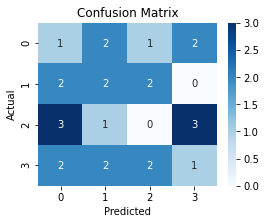

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split



# Create and train the model
lg_model = LogisticRegression(class_weight='balanced', penalty='l2', solver='liblinear', max_iter=1000)
lg_model.fit(X_train, y_train)

# Predict on test set
y_pred = lg_model.predict(X_test)

# Evaluate
cm = confusion_matrix(y_test, y_pred)
print("Logistic Regression\n--------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


C:\Users\aisa\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBoost Classifier
--------------------------
Accuracy: 0.23076923076923078
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.25      0.33      0.29         6
           3       0.25      0.14      0.18         7
           4       0.30      0.43      0.35         7

    accuracy                           0.23        26
   macro avg       0.20      0.23      0.21        26
weighted avg       0.21      0.23      0.21        26



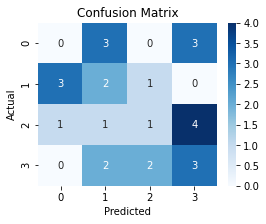

In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Encode labels to 0-based indices
le = LabelEncoder()
y_encoded = le.fit_transform(y_train)

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(
    objective="multi:softmax",
    num_class=len(le.classes_), 
    eval_metric="mlogloss",
    random_state=42
)
xgb_model.fit(X_train, y_encoded)

# Predict on test set
y_pred_encoded = xgb_model.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded) 

# Evaluate performance
cm = confusion_matrix(y_test, y_pred)

print("XGBoost Classifier\n--------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_test, y_pred))


plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(random_state=42)
RF_model.fit(X_train, y_train)

# Predict on test set
y_pred = RF_model.predict(X_test)

# Evaluate performance
print("Random Forest Classifier\n--------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_model),('rf', RF_model),('mlp', MLP_model)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

# Predict on test set
y_pred = voting_clf.predict(X_test)

# Evaluate performance
print("Voting Classifier\n--------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()